In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
Shanghai = pd.read_csv("/Users/kayinho/Downloads/FiveCitiePMData/ShanghaiPM20100101_20151231.csv")


In [3]:
Shanghai.drop(['PM_Jingan', 'season', 'precipitation', 'Iprec', 'cbwd'], 
               axis=1,
              inplace=True)


In [4]:
Shanghai.dropna(axis=0, how="any", inplace=True)
Shanghai['Time'] = pd.to_datetime(Shanghai['year'].map(str) +"/"+ Shanghai['month'].map(str) +"/"+ Shanghai['day'].map(str)+" "+Shanghai['hour'].map(str)+":00:00")


In [5]:
Shanghai_1 = Shanghai.groupby(['Time']).mean()


In [6]:
Shanghai_1.index = pd.to_datetime(Shanghai_1.index, 
                             format='%d-%m-%Y %H:%M:%S')
Shanghai_1 = Shanghai_1.set_index(Shanghai_1.index).asfreq('H')
Shanghai_1 = Shanghai_1.fillna(method='ffill')
Shanghai_1['Time'] = Shanghai_1.index


In [7]:
Shanghai_13 = Shanghai_1[(Shanghai_1['Time'] >=pd.to_datetime('20130501030000')) & (Shanghai_1['Time'] <= pd.to_datetime('20150430030000'))]
Shanghai_13 = Shanghai_13.set_index(Shanghai_13.index).asfreq('D')



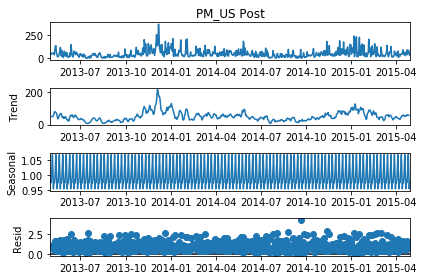

In [8]:
split_result = seasonal_decompose(Shanghai_13['PM_US Post'],  
                            model ='multiplicative') 
split_result.plot();

In [9]:
# Split data into train / test sets 
dataset = Shanghai_13[['PM_US Post','DEWP','HUMI','PRES', 'TEMP', 'Iws']]
train = dataset[:len(dataset)-146]
test = dataset[len(dataset)-146:]

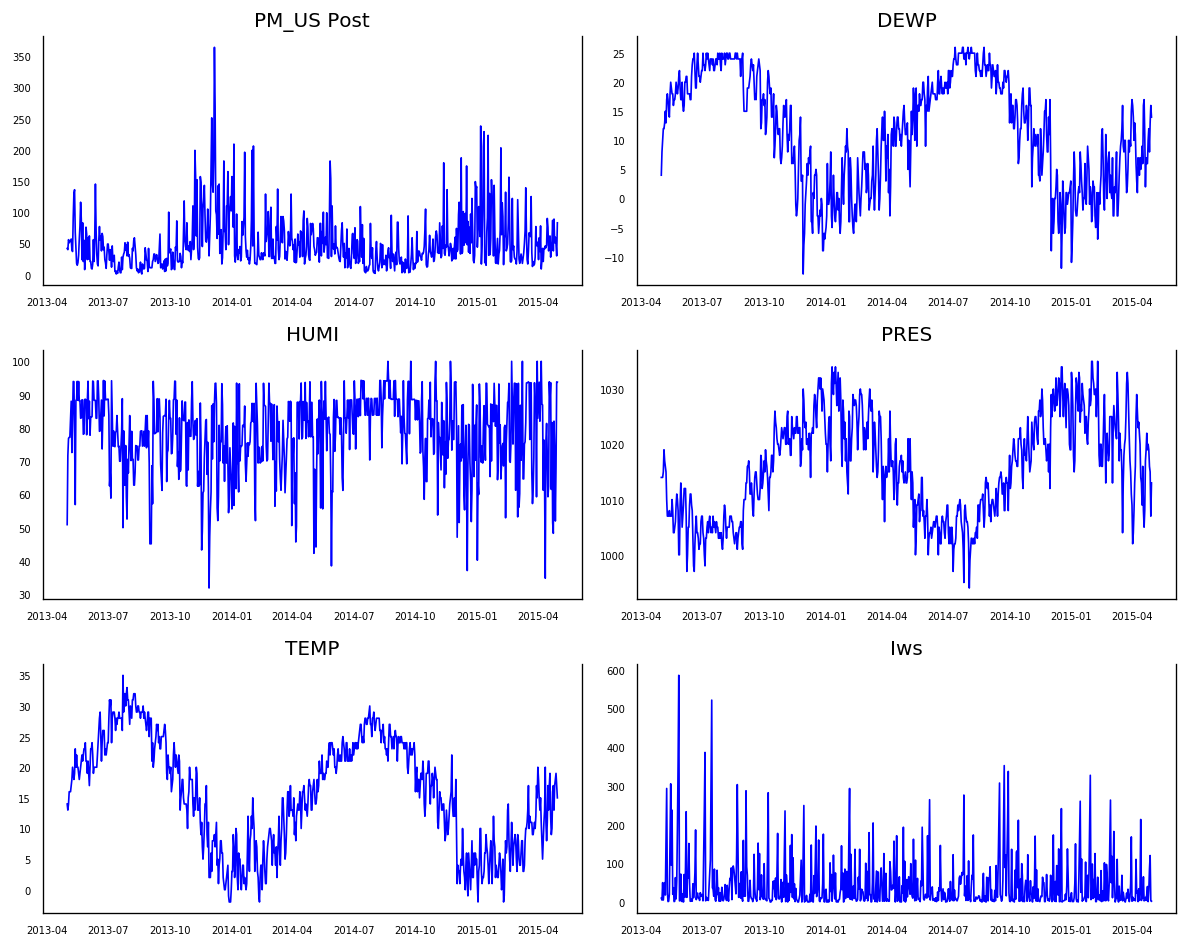

In [10]:
#preliminary plots of each variable
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PM_US Post', fontsize=20)
ax[0] = plot_acf(dataset['PM_US Post'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['PM_US Post'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('DEWP', fontsize=20)
ax[0] = plot_acf(dataset['DEWP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['DEWP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('TEMP', fontsize=20)
ax[0] = plot_acf(dataset['TEMP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['TEMP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PRES', fontsize=20)
ax[0] = plot_acf(dataset['PRES'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['PRES'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Iws', fontsize=20)
ax[0] = plot_acf(dataset['Iws'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Iws'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('HUMI', fontsize=20)
ax[0] = plot_acf(dataset['HUMI'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['HUMI'], ax = ax[1])

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(dataset, variables = dataset.columns) 

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dataset)

In [13]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    #print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    #print(f' Significance Level    = {signif}')
    #print(f' Test Statistic        = {output["test_statistic"]}')
    #print(f' No. Lags Chosen       = {output["n_lags"]}')

    #for key,val in r[4].items():
        #print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        #print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        #print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
          
# ADF Test on each column
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEWP" 
    -----------------------------------------------
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "HUMI" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PRES" 
    -----------------------------------------------
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "TEMP" 
    -----------------------------------------------
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Iws" 
    -----------------------------------------------
 => Series is Stationary.




In [11]:
train_diff = train.diff().dropna()
train_diff

,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws
Time,,,,,,
2013-05-02 03:00:00,-2.0,4.0,20.74,0.0,-1.0,-5.0
2013-05-03 03:00:00,16.0,2.0,5.18,0.0,1.0,45.0
2013-05-04 03:00:00,-5.0,2.0,0.33,1.0,2.0,-45.0
2013-05-05 03:00:00,2.0,0.0,0.00,4.0,0.0,24.0
2013-05-06 03:00:00,2.0,1.0,5.23,-2.0,0.0,21.0
...,...,...,...,...,...,...
2014-12-01 03:00:00,49.0,-10.0,-12.28,11.0,-8.0,61.0
2014-12-02 03:00:00,-37.0,-16.0,-34.47,6.0,-9.0,-24.0
2014-12-03 03:00:00,3.0,7.0,17.76,-4.0,3.0,-44.0


In [14]:
for name, column in train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEWP" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HUMI" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PRES" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TEMP" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Iws" 
    -----------------------------------------------
 => Series is Stationary.




In [15]:
from statsmodels.tsa.api import VAR
model = VAR(train_diff)
    
#x = model.select_order(maxlags=20)
#x.summary()
#min AIC/FPE: lag 7

In [16]:
results = model.fit(maxlags=20, ic='aic')
#results.summary()

In [17]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic: [0,4]; 
#close to 2 = no significant serial correlation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(train_diff.columns, out):
    print(adjust(col), ':', round(val, 2))

PM_US Post : 1.99
DEWP   : 1.99
HUMI   : 2.0
PRES   : 2.03
TEMP   : 2.0
Iws    : 2.01


In [18]:
# Get the lag order
lag_order = results.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input = train_diff.values[-lag_order:]

#results.forecast(dataset.values[-lag_order:], 15)
fc = results.forecast(y=forecast_input, steps=15)
result_forecast = pd.DataFrame(fc, index=dataset.index[-15:], columns=dataset.columns + '_1d')
#print(result_forecast)

In [19]:
def invert_transformation(train, result_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = result_forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+ '_1d'].cumsum()
    return df_fc
df_results = invert_transformation(train, result_forecast)       
#print(df_results.loc[:, ['PM_US Post_forecast','Iws_forecast', 'HUMI_forecast']])

#df_future_result = invert_transformation(train, fc_future)
#print(df_future_result)
     
#print(df_results.loc[:, ['PM_US Post_forecast', 'DEWP_forecast', 'TEMP_forecast', 'PRES_forecast', 'Iws_forecast', 'HUMI_forecast']]) #'

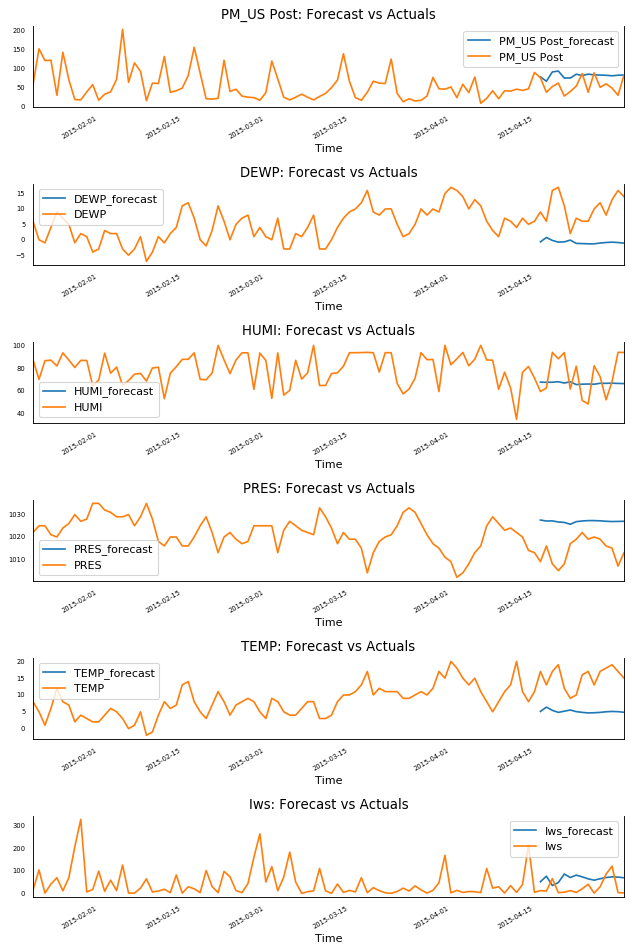

In [20]:
#results.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset[col][-100:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [21]:
test = dataset[len(dataset)-146:]

In [22]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test[['PM_US Post', 'DEWP','HUMI','PRES', 'TEMP', 'Iws']][-15:], 
                                  df_results[['PM_US Post_forecast','DEWP_forecast','HUMI_forecast','PRES_forecast', 'TEMP_forecast', 'Iws_forecast']][-15:]))
print("Overall RMSE: ", rmse)

Overall RMSE:  28.053959603411244


In [23]:
rmse_PM = np.sqrt(mean_squared_error(test[['PM_US Post']][-15:], 
                                  df_results[['PM_US Post_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_forecast: ", rmse_PM)

rmse_DEWP = np.sqrt(mean_squared_error(test[['DEWP']][-15:], 
                                  df_results[['DEWP_forecast']][-15:]))
print("RMSE for DEWP_forecast: ", rmse_DEWP)

rmse_HUMI = np.sqrt(mean_squared_error(test[['HUMI']][-15:], 
                                  df_results[['HUMI_forecast']][-15:]))
print("RMSE for HUMI_forecast: ", rmse_HUMI)

rmse_PRES = np.sqrt(mean_squared_error(test[['PRES']][-15:], 
                                  df_results[['PRES_forecast']][-15:]))
print("RMSE for PRES_forecast: ", rmse_PRES)

rmse_TEMP = np.sqrt(mean_squared_error(test[['TEMP']][-15:], 
                                  df_results[['TEMP_forecast']][-15:]))
print("RMSE for TEMP_forecast: ", rmse_TEMP)

rmse_Iws = np.sqrt(mean_squared_error(test[['Iws']][-15:], 
                                  df_results[['Iws_forecast']][-15:]))
print("RMSE for Iws_forecast ", rmse_Iws)

RMSE for Shanghai_PM2.5_forecast:  32.09454286204986
RMSE for DEWP_forecast:  11.820344551391116
RMSE for HUMI_forecast:  17.78576270852464
RMSE for PRES_forecast:  13.804207726321682
RMSE for TEMP_forecast:  10.662210887973336
RMSE for Iws_forecast  54.14605639052967


In [ ]:
#impulse response analysis
irf = results.irf(10)
irf.plot(orth=False);

In [ ]:
#impulse response analysis wiht cumulative effect
irf.plot_cum_effects(orth=False);

In [ ]:
resid = results.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [ ]:
#Forecast Error Variance Decomposition (FEVD) method
fevd = results.fevd(5)
fevd.summary()

In [ ]:
results.fevd(20).plot();

In [87]:
# Split data into train / test sets 
dataset2 = Shanghai_13[['PM_US Post','HUMI', 'Iws']]
dataset2.columns = ['PM_US Post_w/HUMI_Iws','HUMI', 'Iws']
train2 = dataset2[:len(dataset)-146]
test2 = dataset2[len(dataset)-146:]

In [88]:
# ADF Test on each column
for name, column in train2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post_w/HUMI_Iws" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HUMI" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Iws" 
    -----------------------------------------------
 => Series is Stationary.




In [89]:
train2_diff = train2.diff().dropna()
train2_diff

,PM_US Post_w/HUMI_Iws,HUMI,Iws
Time,,,
2013-05-02 03:00:00,-2.0,20.74,-5.0
2013-05-03 03:00:00,16.0,5.18,45.0
2013-05-04 03:00:00,-5.0,0.33,-45.0
2013-05-05 03:00:00,2.0,0.00,24.0
2013-05-06 03:00:00,2.0,5.23,21.0
...,...,...,...
2014-12-01 03:00:00,49.0,-12.28,61.0
2014-12-02 03:00:00,-37.0,-34.47,-24.0
2014-12-03 03:00:00,3.0,17.76,-44.0


In [90]:
model2 = VAR(train2_diff)
    
x2 = model2.select_order(maxlags=30)
#x2.summary()

In [91]:
results2 = model2.fit(maxlags=30, ic='aic')
#results2.summary()

In [92]:
lag_order2 = results2.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input2 = train2_diff.values[-lag_order2:]

#results.forecast(dataset.values[-lag_order:], 30)
fc2 = results2.forecast(y=forecast_input2, steps=15)
result_forecast2 = pd.DataFrame(fc2, index=dataset2.index[-15:], columns=dataset2.columns + '_1d')
#print(result_forecast)

In [93]:
df_results2 = invert_transformation(train2, result_forecast2)  

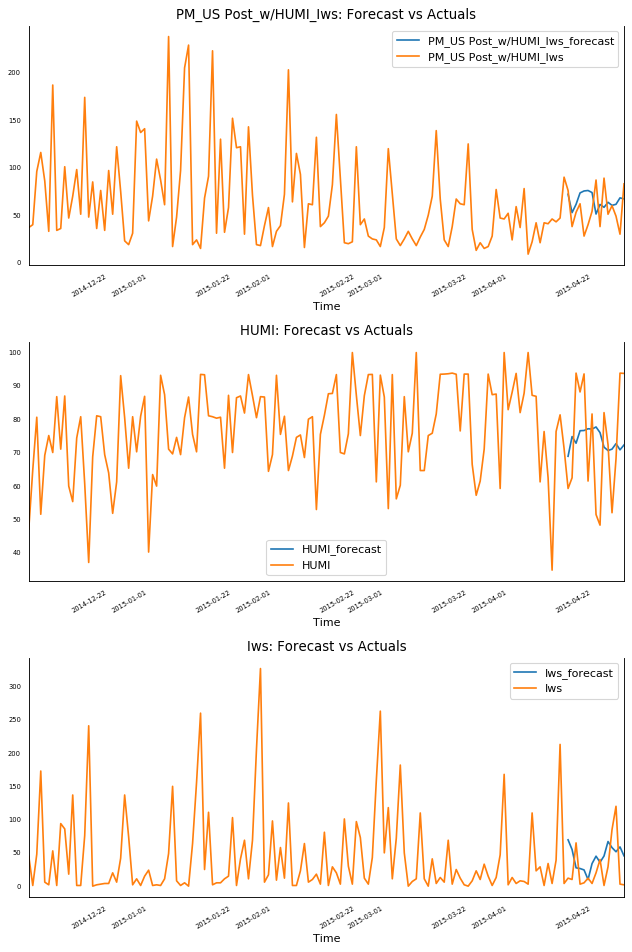

In [94]:
#results2.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset2.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset2.columns, axes.flatten())):
    df_results2[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset2[col][-150:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [95]:
test2 = dataset2[len(dataset2)-146:]

In [96]:
rmse2 = np.sqrt(mean_squared_error(test2[['PM_US Post_w/HUMI_Iws','HUMI','Iws']][-15:], 
                                  df_results2[['PM_US Post_w/HUMI_Iws_forecast','HUMI_forecast','Iws_forecast']][-15:]))
print("Overall RMSE: ", rmse2)

Overall RMSE:  28.493048906157103


In [97]:
rmse_PM2 = np.sqrt(mean_squared_error(test2[['PM_US Post_w/HUMI_Iws']][-15:], 
                                  df_results2[['PM_US Post_w/HUMI_Iws_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_forecast: ", rmse_PM2)

rmse_HUMI2 = np.sqrt(mean_squared_error(test2[['HUMI']][-15:], 
                                  df_results2[['HUMI_forecast']][-15:]))
print("RMSE for HUMI_forecast: ", rmse_HUMI2)

rmse_Iws2 = np.sqrt(mean_squared_error(test2[['Iws']][-15:], 
                                  df_results2[['Iws_forecast']][-15:]))
print("RMSE for Iws_forecast ", rmse_Iws2)

RMSE for Shanghai_PM2.5_forecast:  24.72666965880946
RMSE for HUMI_forecast:  16.95161439190772
RMSE for Iws_forecast  39.201990829524966


In [104]:
# Split data into train / test sets 
dataset3 = Shanghai_13[['PM_US Post','HUMI']]
dataset3.columns = ['PM_US Post_w/HUMI','HUMI']
train3 = dataset3[:len(dataset)-146]
test3 = dataset3[len(dataset)-146:]


In [105]:
# ADF Test on each column
for name, column in train3.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post_w/HUMI" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HUMI" 
    -----------------------------------------------
 => Series is Stationary.




In [106]:
train3_diff = train3.diff().dropna()
train3_diff

,PM_US Post_w/HUMI,HUMI
Time,,
2013-05-02 03:00:00,-2.0,20.74
2013-05-03 03:00:00,16.0,5.18
2013-05-04 03:00:00,-5.0,0.33
2013-05-05 03:00:00,2.0,0.00
2013-05-06 03:00:00,2.0,5.23
...,...,...
2014-12-01 03:00:00,49.0,-12.28
2014-12-02 03:00:00,-37.0,-34.47
2014-12-03 03:00:00,3.0,17.76


In [107]:
model3 = VAR(train3_diff)
    
x3 = model3.select_order(maxlags=30)
#x3.summary()


In [108]:
results3 = model3.fit(maxlags=30, ic='aic')
#results3.summary()

In [109]:
lag_order3 = results3.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input3 = train3_diff.values[-lag_order3:]

#results.forecast(dataset.values[-lag_order:], 30)
fc3 = results3.forecast(y=forecast_input3, steps=15)
result_forecast3 = pd.DataFrame(fc3, index=dataset3.index[-15:], columns=dataset3.columns +'_1d')
#print(result_forecast)

In [110]:
df_results3 = invert_transformation(train3, result_forecast3)  

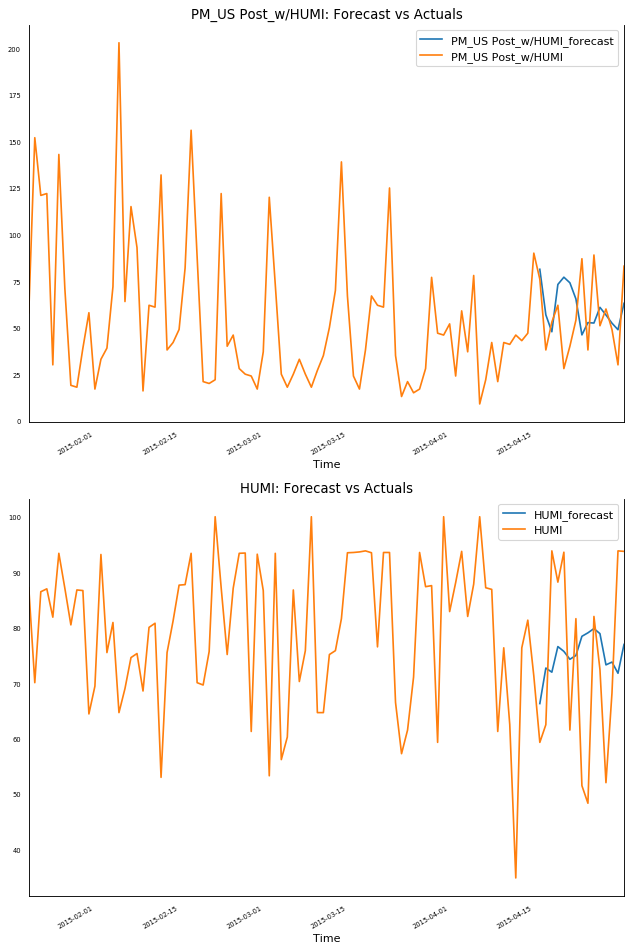

In [111]:
#results3.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset3.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset3.columns, axes.flatten())):
    df_results3[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset3[col][-100:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [112]:
test3 = dataset3[len(dataset3)-146:]

In [113]:
rmse3 = np.sqrt(mean_squared_error(test3[['PM_US Post_w/HUMI','HUMI']][-15:], 
                                  df_results3[['PM_US Post_w/HUMI_forecast','HUMI_forecast']][-15:]))
print("Overall RMSE: ", rmse3)

Overall RMSE:  20.492901894222094


In [114]:
rmse_PM3 = np.sqrt(mean_squared_error(test3[['PM_US Post_w/HUMI']][-15:], 
                                  df_results3[['PM_US Post_w/HUMI_forecast']][-15:]))
print("RMSE for Shanghai_PM3.5_forecast: ", rmse_PM3)

rmse_HUMI3 = np.sqrt(mean_squared_error(test3[['HUMI']][-15:], 
                                  df_results3[['HUMI_forecast']][-15:]))
print("RMSE for HUMI_forecast: ", rmse_HUMI3)


RMSE for Shanghai_PM3.5_forecast:  23.569928539710496
RMSE for HUMI_forecast:  16.863467162044806


In [117]:
# Split data into train / test sets 
dataset4 = Shanghai_13[['PM_US Post','Iws']]
dataset4.columns = ['PM_US Post_w/Iws','Iws']
train4 = dataset4[:len(dataset)-146]
test4 = dataset4[len(dataset)-146:]
# ADF Test on each column
for name, column in train4.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

train4_diff = train4.diff().dropna()
train4_diff

model4 = VAR(train4_diff)
    
#x4 = model4.select_order(maxlags=40)
#x4.summary()

results4 = model4.fit(maxlags=30, ic='aic')
#results3.summary()

lag_order4 = results4.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input4 = train4_diff.values[-lag_order4:]

#results.forecast(dataset.values[-lag_order:], 40)
fc4 = results4.forecast(y=forecast_input4, steps=15)
result_forecast4 = pd.DataFrame(fc4, index=dataset4.index[-15:], columns=dataset4.columns + '_1d')
#print(result_forecast)

df_results4 = invert_transformation(train4, result_forecast4)  

    Augmented Dickey-Fuller Test on "PM_US Post_w/Iws" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Iws" 
    -----------------------------------------------
 => Series is Stationary.




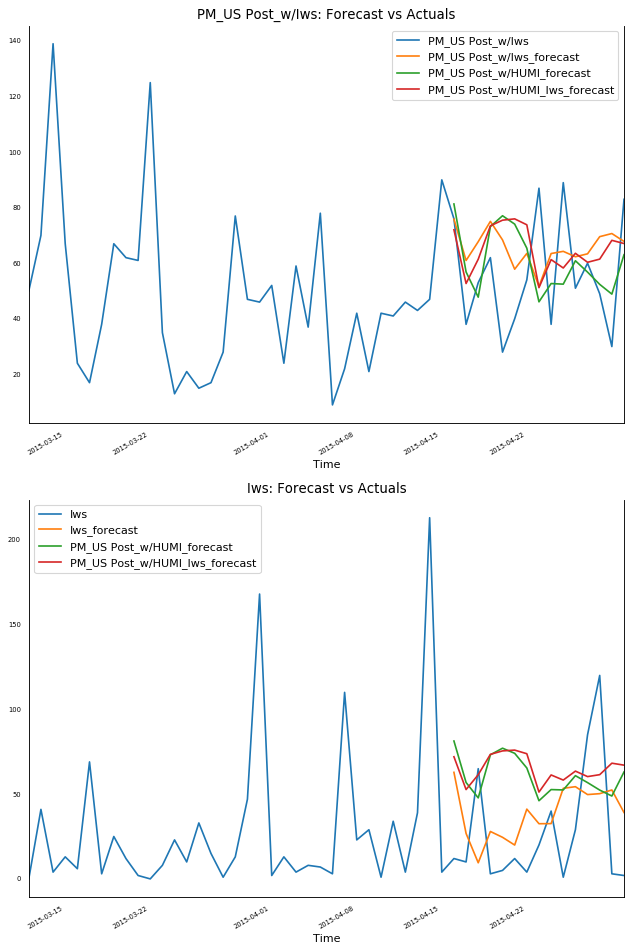

In [119]:
#results4.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset4.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset4.columns, axes.flatten())):
    dataset4[col][-50:].plot(legend=True, ax=ax);
    df_results4[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_results3['PM_US Post_w/HUMI_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_results2['PM_US Post_w/HUMI_Iws_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [48]:
test4 = dataset4[len(dataset4)-146:]
rmse4 = np.sqrt(mean_squared_error(test4[['PM_US Post','Iws']][-15:], 
                                  df_results4[['PM_US Post_forecast','Iws_forecast']][-15:]))
print("Overall RMSE: ", rmse4)

rmse_PM4 = np.sqrt(mean_squared_error(test4[['PM_US Post']][-15:], 
                                  df_results4[['PM_US Post_forecast']][-15:]))
print("RMSE for Shanghai_PM2.5_forecast: ", rmse_PM4)

rmse_Iws4 = np.sqrt(mean_squared_error(test4[['Iws']][-15:], 
                                  df_results4[['Iws_forecast']][-15:]))
print("RMSE for Iws_forecast: ", rmse_Iws4)

Overall RMSE:  31.54233066108149
RMSE for Shanghai_PM2.5_forecast:  22.97350922584244
RMSE for Iws_forecast:  38.23682937844265


In [120]:
print("RMSE for Shanghai_PM2.5_forecast (ALL): ", rmse_PM)
print("RMSE for Shanghai_PM2.5_forecast (HUMI, Iws) : ", rmse_PM2)
print("RMSE for Shanghai_PM2.5_forecast (HUMI) : ", rmse_PM3)
print("RMSE for Shanghai_PM2.5_forecast (Iws) : ", rmse_PM4)

RMSE for Shanghai_PM2.5_forecast (ALL):  32.09454286204986
RMSE for Shanghai_PM2.5_forecast (HUMI, Iws) :  24.72666965880946
RMSE for Shanghai_PM2.5_forecast (HUMI) :  23.569928539710496
RMSE for Shanghai_PM2.5_forecast (Iws) :  22.97350922584244
